In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from keras.callbacks import EarlyStopping



In [2]:
bank = pd.read_csv("bank.csv")

In [3]:
bank.shape

(11162, 17)

In [4]:
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no


In [5]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


<Figure size 1080x1080 with 0 Axes>

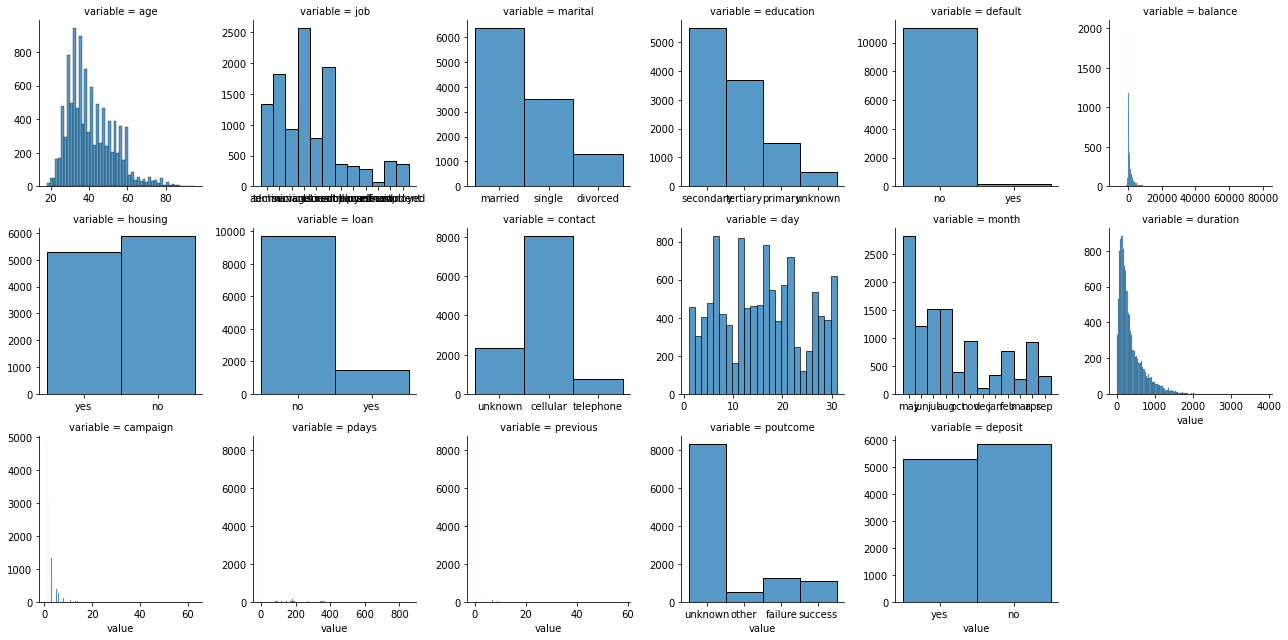

In [6]:
plt.figure(figsize=(15,15))
f = pd.melt(bank)
facet = sns.FacetGrid(f, col_wrap=6, col="variable", sharex=False, sharey=False)
facet = facet.map(sns.histplot, "value", kde=False)
plt.show()

In [7]:
print("We have %d missing values in this dataset." % bank.isna().sum().sum())

We have 0 missing values in this dataset.


C:\Users\pc\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 2520x1080 with 0 Axes>

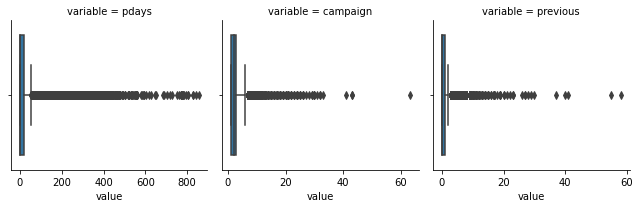

In [8]:
plt.figure(figsize=(35,15))
f = pd.melt(bank[["pdays", "campaign", "previous"]])
facet = sns.FacetGrid(f, col_wrap=3, col="variable", sharex=False, sharey=False)
facet = facet.map(sns.boxplot, "value")
plt.show()

- Value -1 in *"previous"* features means that the client was never contacted on any other campaign prior to this one.
- Value 0 in *"pdays"* means that zero days have passed after the client was last contacted from a previous campaign.

Frequencies of ```previous = -1``` and ```pdays = 0``` should be equivalent.


In [9]:
previous_groups = bank.groupby(by="previous").previous.count()
pdays_groups = bank.groupby(by="pdays").pdays.count().sort_values(ascending=False)
campaign_groups = bank.groupby(by="campaign").campaign.count().sort_values(ascending=False)

pd.DataFrame([previous_groups, pdays_groups, campaign_groups]).T.replace({"NaN": "-"})

,previous,pdays,campaign
-1,NaN,8324.0,NaN
0,8324.0,NaN,NaN
1,887.0,8.0,4798.0
2,693.0,8.0,3028.0
3,435.0,NaN,1321.0
...,...,...,...
805,NaN,1.0,NaN
826,NaN,1.0,NaN
828,NaN,1.0,NaN
842,NaN,1.0,NaN


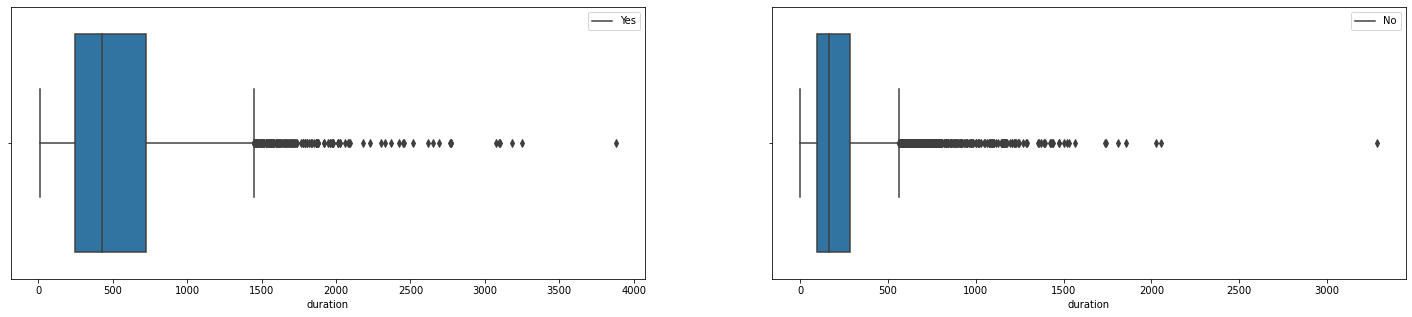

In [16]:
plt.figure(figsize=[25, 5])
plt.subplot(121)
sns.boxplot(data=bank[bank.deposit == "yes"], x="duration")
plt.legend(["Yes"])
plt.subplot(122)
sns.boxplot(data=bank[bank.deposit == "no"], x="duration")
plt.legend(["No"])
plt.show()

We will now remove all the outliers based on **"Duration"** feature

In [36]:
# Yes Count
Q1 = bank[(bank.deposit == "yes")].duration.describe()["25%"]
Q3 = bank[(bank.deposit == "yes")].duration.describe()["75%"]
threshold1 = Q3 + 1.5*(Q3-Q1)

# No count
Q1 = bank[(bank.deposit == "no")].duration.describe()["25%"]
Q3 = bank[(bank.deposit == "no")].duration.describe()["75%"]
threshold2 = Q3 + 1.5*(Q3-Q1)


new_bank = bank[((bank.deposit == "yes")&(bank.duration <= threshold1)) | ((bank.deposit == "no")&(bank.duration <= threshold2))]


In [123]:
# Shuffling the dataset
np.random.seed(42)
new_bank = new_bank.sample(frac=1).reset_index(drop=True)

In [124]:
# new_bank.day = new_bank.day.astype("category")

from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1- Rescale the numerical features
df_numerical_features = new_bank.select_dtypes(include="number")
numerical_features = df_numerical_features.columns

ss = StandardScaler()

df_numerical_features = ss.fit_transform(df_numerical_features)

# # 2- Label encode Categorical features 
df_categorical_features = new_bank.select_dtypes(exclude="number")
categorical_features = df_categorical_features.columns
le = LabelEncoder()

df_categorical_features = [le.fit_transform(df_categorical_features[feature]) for feature in df_categorical_features]



In [125]:
# np.hstack((df_numerical_features, np.array(df_categorical_features).transpose()))
# len(df_numerical_features), len(df_categorical_features)
# df_numerical_features.shape, np.array(df_categorical_features).transpose().shape
# len(new_bank.job.unique())
# df_numerical_features.shape

In [128]:
data = pd.DataFrame(data=np.hstack((df_numerical_features, np.array(df_categorical_features).transpose())), 
            columns=numerical_features.append(categorical_features))

X_train, X_test, Y_train, Y_test = train_test_split(data.drop("deposit", axis=1), data.deposit, test_size=0.2, random_state=42)


In [229]:
batch_size = 256
epoch = 20

In [230]:
model = Sequential([
    Dense(512, kernel_initializer="he_normal", input_dim=X_train.shape[1], activation="relu"),
    Dense(256, kernel_initializer="he_normal", activation="relu"),
    # Dropout(0.2),
    Dense(128, kernel_initializer="he_normal", activation="relu"),
    Dropout(0.2),
    Dense(64, kernel_initializer="he_normal", activation="relu"),
    Dense(32, kernel_initializer="he_normal", activation="relu"),
    Dropout(0.2),
    Dense(units=1, kernel_initializer="he_normal", activation="sigmoid")

], name="Bank_Deposit_Forcast")

model.summary()

Model: "Bank_Deposit_Forcast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 512)               8704      
_________________________________________________________________
dense_105 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_106 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_107 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_108 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)       

In [231]:
model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")

# callback functions to early stop training 
callbacks = [EarlyStopping(monitor='val_loss', patience=4)]

with tf.device("/GPU:1"):
    history_model = model.fit(X_train[:-1000], Y_train[:-1000],
        validation_data=(X_train[-1000:], Y_train[-1000:]),
        batch_size=batch_size,
        epochs=epoch,
        verbose=1,
        callbacks=callbacks
    )

Epoch 1/20
30/30 [==============================] - 1s 13ms/step - loss: 0.8925 - accuracy: 0.5655 - val_loss: 0.5440 - val_accuracy: 0.7660
Epoch 2/20
30/30 [==============================] - 0s 5ms/step - loss: 0.5060 - accuracy: 0.7439 - val_loss: 0.4044 - val_accuracy: 0.8110
Epoch 3/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4283 - accuracy: 0.7999 - val_loss: 0.3874 - val_accuracy: 0.8210
Epoch 4/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4092 - accuracy: 0.8122 - val_loss: 0.4014 - val_accuracy: 0.8090
Epoch 5/20
30/30 [==============================] - 0s 6ms/step - loss: 0.4006 - accuracy: 0.8172 - val_loss: 0.3618 - val_accuracy: 0.8360
Epoch 6/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3861 - accuracy: 0.8263 - val_loss: 0.3714 - val_accuracy: 0.8300
Epoch 7/20
30/30 [==============================] - 0s 6ms/step - loss: 0.3825 - accuracy: 0.8270 - val_loss: 0.3570 - val_accuracy: 0.8470
Epoch 8/20
30/30 [=

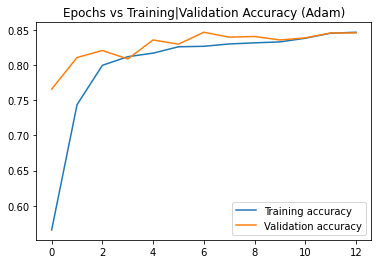

In [232]:
# plt.figure(figsize=[25,4])

# plt.subplot(121)
train_accuracy = history_model.history["accuracy"]
validation_accuracy = history_model.history["val_accuracy"]
count = range(len(train_accuracy))

train_loss = history_model.history["loss"]
plt.plot(count, train_accuracy, label='Training accuracy')
plt.plot(count, validation_accuracy, label='Validation accuracy')
# plt.plot(count, train_loss, label='Training Loss')
plt.title('Epochs vs Training|Validation Accuracy (Adam)')
plt.legend()
plt.show()


In [233]:
test_logits= model.predict(X_test)
test_predictions = np.array(list(map(lambda x: 1 if x > 0.5 else 0, test_logits[:,0])))
# test_logits

f1 score = 0.828


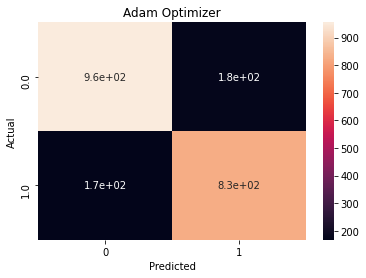

In [234]:
print("f1 score = %.3f" % f1_score(Y_test, test_predictions))
confusion_matrix = pd.crosstab(Y_test, test_predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.title("Adam Optimizer")
plt.show()